In [2]:
# Import libraries
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from bs4 import BeautifulSoup
import pandas as pd
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def _rawDataextract_(path):
    
    html_tables = {}
    parsed_news = []
    
    for file_name in os.listdir(path):
        file_path = os.path.join(path, file_name)
        html_file = open(file_path, 'r')
        html_content = BeautifulSoup(open(file_path, 'r'))
        html_table = html_content.find(id='news-table')
        html_tables[file_name] = html_table
    
    for file_name, news_table in html_tables.items():
        
        for x in news_table.findAll('tr'):
            #text = x.get_text()
            date_scrape = x.td.text.split()
            headline = x.a.text
        
            
            if len(date_scrape) == 1:
                time = date_scrape[0]
            
            else:
                date = date_scrape[0]
                time = date_scrape[1]
                
            ticker = file_name.split('_')[0]
            parsed_news.append([ticker, date, time, headline])
    return parsed_news

In [4]:
#creating new words with value
new_words = {'crushes' : 10,
            'beats': 5,
            'misses': -5,
            'trouble': -10,
            'falls': -100}

# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()

#update the lexicon
vader.lexicon.update(new_words)

In [5]:
#creating columns
columns = ['ticker', 'date', 'time', 'headline']

#convert the list of lists into a Dataframe
scored_news = pd.DataFrame(_rawDataextract_('Data'), columns = columns)

#iterate through the headline and get the polarity scores
scores = scored_news['headline'].apply(vader.polarity_scores)

#Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame.from_records(scores)

# Join the DataFrames
scored_news = scored_news.join(scores_df)

# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

#print(scored_news.head())

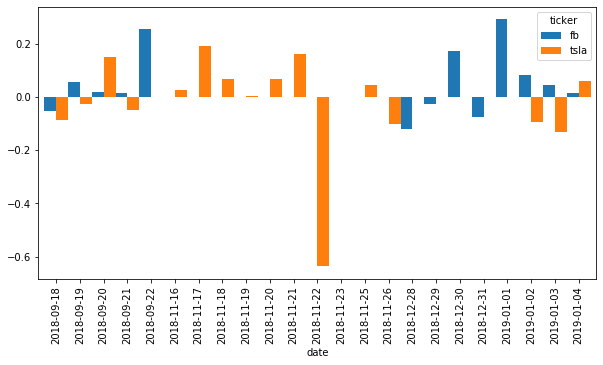

In [6]:
#Group by date and ticker columns from scored_news and calculate the mean
mean_scored_news = scored_news.groupby(['date', 'ticker']).mean()

# Unstack the column ticker
mean_scored_news = mean_scored_news.unstack('ticker')

#Get the cross-section of compound in the 'columns' axis
mean_scored_news = mean_scored_news.xs('compound', axis='columns')

#plot the bar chart
mean_scored_news.plot(kind='bar', figsize=(10,5), width=1)

In [7]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = scored_news['headline'].count()

# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset=['ticker','headline'])
                      
# Count number of headlines after dropping duplicates
num_news_after = scored_news_clean['headline'].count()                        

In [8]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])

# Cross-section the fb row
single_day = single_day.xs('fb')

# Select the 3rd of January of 2019
single_day = single_day['2019-01-3']

# Convert the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time']).dt.time

# Set the index to time and 
single_day = single_day.set_index('time')

# Sort it
single_day = single_day.sort_index()
print(single_day.info())

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 06:00:00 to 22:59:00
Data columns (total 5 columns):
headline    19 non-null object
neg         19 non-null float64
neu         19 non-null float64
pos         19 non-null float64
compound    19 non-null float64
dtypes: float64(4), object(1)
memory usage: 912.0+ bytes
None


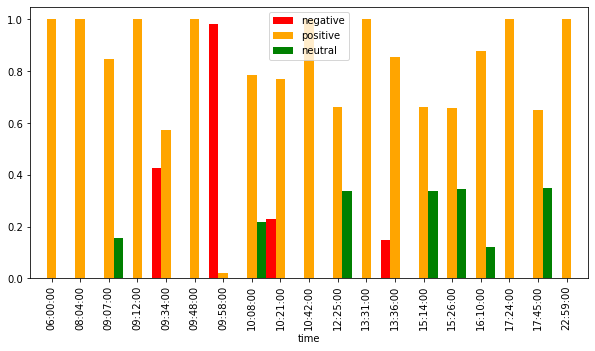

In [9]:
TITLE = "Positive, negative and neutral sentiment for FB on 2019-01-03"
COLORS = ["red", "orange", "green"]

# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['headline', 'compound'], axis=1)

# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'positive', 'neutral']

# Plot a stacked bar chart
plot_day.plot(kind='bar', color=COLORS, figsize=(10,5), width=1)